# Manual Neural Network

In this notebook we will manually (using Python without Tensorflow or any other ML library) build out a neural network that mimics the TensorFlow API. This will greatly help our understanding when working with the TensorFlow!

____
### Quick Note on Super() and OOP

In [86]:
class SimpleClass():x
    def __init__(self,str_input):
        print("SIMPLE" + str_input)

In [87]:
class ExtendedClass(SimpleClass):
    def __init__(self):
        print('EXTENDED')

In [88]:
s = ExtendedClass()

EXTENDED


In [89]:
class ExtendedClass(SimpleClass):
    def __init__(self):
        super().__init__(" My String")
        print('EXTENDED')

In [90]:
s = ExtendedClass()

SIMPLE My String
EXTENDED


________

## Operations

In [91]:
class Operation():
    """
    An Operation is a node in a "Graph". TensorFlow will also use this concept of a Graph.
    
    This Operation class will be inherited by other classes that actually compute the specific
    operation, such as adding or matrix multiplication.
    """
    
    def __init__(self, input_nodes = []):
        """
        Intialize an Operation
        """
        self.input_nodes = input_nodes # The list of input nodes
        self.output_nodes = [] # List of nodes consuming this node's output
        
        # For every node in the input, we append this operation (self) to the list of
        # the consumers of the input nodes
        for node in input_nodes:
            node.output_nodes.append(self)
        
        # There will be a global default graph (TensorFlow works this way)
        # We will then append this particular operation
        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)
  
    def compute(self):
        """ 
        This is a placeholder function. It will be overwritten by the actual specific operation
        that inherits from this class.
        
        """
        pass

In [92]:
class add(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var

In [93]:
class multiply(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])
    def compute(self, a_var, b_var):
        self.inputs = [a_var, b_var]
        return a_var * b_var

In [94]:
class matmul(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])
    def compute(self, a_mat, b_mat):
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

## Placeholders

In [95]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a value for computing the output in the Graph.
    """
    def __init__(self):
        self.output_nodes = []
        _default_graph.placeholders.append(self)

## Variables

In [96]:
class Variable():
    """
    This variable is a changeable parameter of the Graph.
    """
    def __init__(self, initial_value = None):
        self.value = initial_value
        self.output_nodes = []
        _default_graph.variables.append(self)

## Graph

In [97]:
class Graph():
    def __init__(self):
        self.operations = []
        self.placeholders = []
        self.variables = []
    def set_as_default(self):
        """ Sets this Graph instance as the Global Default Graph """
        global _default_graph
        _default_graph = self

## A Basic Graph

$$ z = Ax + b $$

With A=10 and b=1

$$ z = 10x + 1 $$

Just need a placeholder for x and then once x is filled in we can solve it!

In [98]:
g = Graph()

In [99]:
g.set_as_default()

In [100]:
A = Variable(10)

In [101]:
b = Variable(1)

In [102]:
x = Placeholder() # Will be filled out later

In [103]:
y = multiply(A,x)

In [104]:
z = add(y,b)

## Session

In [105]:
import numpy as np

### Traversing Operation Nodes

In [106]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b).
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

In [107]:
class Session:
    
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to input values (the data)  
        """
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:
            if type(node) == Placeholder:
                node.output = feed_dict[node]
            elif type(node) == Variable:
                node.output = node.value
            else: # Operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        return operation.output # Return the requested node value




In [108]:
sess = Session()

In [109]:
result = sess.run(operation=z,feed_dict={x:10})

In [110]:
result

101

In [111]:
10*10 + 1

101

# Classification
### Activation Function

In [112]:
import matplotlib.pyplot as plt

In [113]:
%matplotlib inline

In [114]:
def sigmoid(z):
    return 1 / (1+np.exp(-z)) #np.exp(-z) -> e ^ -z

In [115]:
sample_z = np.linspace(-10, 10, 100) #creates evenly spaced arrays; in this case, 100 numbers between -10 and 10
sample_a = sigmoid(sample_z)

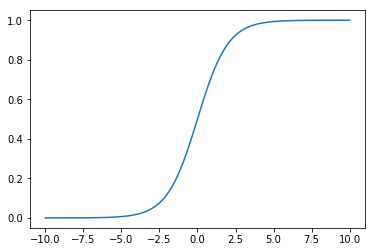

In [116]:
plt.plot(sample_z, sample_a)

In [138]:
class Sigmoid(Operation):
    def __init__(self, z):
        super().__init__([z])
    def compute(self, z_val):
        return 1 / (1+np.exp(-z_val)) #np.exp(-z_val) => e ^ -z

In [139]:
from sklearn.datasets import make_blobs

In [140]:
data = make_blobs(n_samples=50, n_features=2, centers=2, random_state=75) #creates some blobs (clusters) to classify

In [141]:
data #the array at the end is the set of labels for each data point

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

In [142]:
type(data)

tuple

In [143]:
data[0] #the features

array([[  7.3402781 ,   9.36149154],
       [  9.13332743,   8.74906102],
       [  1.99243535,  -8.85885722],
       [  7.38443759,   7.72520389],
       [  7.97613887,   8.80878209],
       [  7.76974352,   9.50899462],
       [  8.3186688 ,  10.1026025 ],
       [  8.79588546,   7.28046702],
       [  9.81270381,   9.46968531],
       [  1.57961049,  -8.17089971],
       [  0.06441546,  -9.04982817],
       [  7.2075117 ,   7.04533624],
       [  9.10704928,   9.0272212 ],
       [  1.82921897,  -9.86956281],
       [  7.85036314,   7.986659  ],
       [  3.04605603,  -7.50486114],
       [  1.85582689,  -6.74473432],
       [  2.88603902,  -8.85261704],
       [ -1.20046211,  -9.55928542],
       [  2.00890845,  -9.78471782],
       [  7.68945113,   9.01706723],
       [  6.42356167,   8.33356412],
       [  8.15467319,   7.87489634],
       [  1.92000795,  -7.50953708],
       [  1.90073973,  -7.24386675],
       [  7.7605855 ,   7.05124418],
       [  6.90561582,   9.23493842],
 

In [144]:
data[1] #the labels

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1])

In [145]:
features = data[0]
labels = data[1]

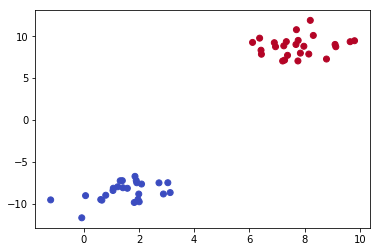

In [146]:
plt.scatter(features[:,0],features[:,1],c=labels,cmap='coolwarm') #all rows in columns 0 on x-axis and all rows in column 1 on y-axis; c is to color the data points

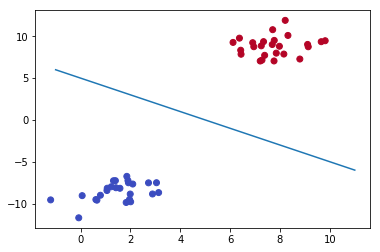

In [147]:
x = np.linspace(-1,11,10)
y = -x + 5
plt.scatter(features[:,0],features[:,1],c=labels,cmap='coolwarm')
plt.plot(x,y)

# (1,1) * f - 5 = 0, where f is feature matrix. If result is > 0, above line in red. 

In [148]:
np.array([1,1]).dot(np.array([[8],[10]])) - 5 #result is 13 > 0, therefore the data point belongs in the red cluster; .dot is dot product (matrix multiplication)

array([13])

In [149]:
np.array([1,1]).dot(np.array([[2], [-10]])) - 5 #result is -13 < 0, so the data point belongs in the blue cluster

array([-13])

In [150]:
g = Graph()

In [151]:
g.set_as_default()

In [152]:
x = Placeholder()

In [153]:
w = Variable([1,1])

In [154]:
b = Variable(-5)

In [155]:
z = add(matmul(w,x), b)

In [156]:
a = Sigmoid(z) #outputs between 0 and 1; the further from 0 the input, the more sure our model is of the classification (since our classification relies on whether the data point is positive or negative)

In [157]:
sess = Session()

In [160]:
sess.run(operation=a, feed_dict={x:[8,10]}) #output is 0.99999... , so model is very sure that data point belongs to class 1 (red / positive)

0.99999773967570205

In [162]:
sess.run(operation=a, feed_dict={x:[2,-10]}) #output is very close to 0, model is very sure that data point belongs to blue class

2.2603242979035746e-06